In [190]:
#Import the packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import wget
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [5]:
#Download the most recent caseshiller dataset from https://fred.stlouisfed.org/
def nationCaseShillerDownload():
    date=str(date.today())
    file_url="https://fred.stlouisfed.org/graph/fredgraph.csv?chart_type=line&recession_bars=on&log_scales=&bgcolor=%23e1e9f0&graph_bgcolor=%23ffffff&fo=Open+Sans&ts=12&tts=12&txtcolor=%23444444&show_legend=yes&show_axis_titles=yes&drp=0&cosd=1987-01-01&coed={}&height=450&stacking=&range=&mode=fred&id=CSUSHPINSA&transformation=lin&nd=1987-01-01&ost=-99999&oet=99999&lsv=&lev=&mma=0&fml=a&fgst=lin&fgsnd=2009-06-01&fq=Monthly&fam=avg&vintage_date=&revision_date=&line_color=%234572a7&line_style=solid&lw=2&scale=left&mark_type=none&mw=2&width=1168"
    new_url=file_url.format(date)
    file=wget.download(new_url)
nationCaseShillerDownload()

In [223]:
def nextmonth(date):
    newdate=datetime.strptime(date, '%Y-%m-%d')+relativedelta(months=1)
    newdate=str(newdate.date())
    return newdate

In [224]:

#Read and format the csv file into pandas dataframe
file=pd.read_csv("CSUSHPINSA.csv")
df=pd.DataFrame(file)
df=df.rename(columns={"CSUSHPINSA":"Case-Shiller_index"})
df=df.append({"DATE":nextmonth(df[-1:]["DATE"].values[0]),"Case-Shiller_index":None},ignore_index=True)

In [226]:
#Simple Moving Average Function
def SMA(srs,period):
    new_srs=srs.rolling(period).mean()
    return new_srs

In [227]:
#Use the SMA function to make forecasting for different time period
df["SMA_6"]=SMA(df["Case-Shiller_index"][:-1],6)
df["SMA_6"]=df["SMA_6"].shift(1)
df["SMA_12"]=SMA(df["Case-Shiller_index"][:-1],12)
df["SMA_12"]=df["SMA_12"].shift(1)
df["SMA_3"]=SMA(df["Case-Shiller_index"][:-1],3)
df["SMA_3"]=df["SMA_3"].shift(1)
df["DATE"]=pd.to_datetime(df["DATE"])

In [228]:
#Calculate the Absolute Error for SMA forecasting models
df["SMA_3_AbsError"]=abs(df["SMA_3"]-df["Case-Shiller_index"])
df["SMA_6_AbsError"]=abs(df["SMA_6"]-df["Case-Shiller_index"])
df["SMA_12_AbsError"]=abs(df["SMA_12"]-df["Case-Shiller_index"])

In [230]:
df.to_excel("SMA_Caseshiller.xls")

In [21]:
#Test Stationality
dtest=adfuller(df["Case-Shiller_index"])

In [22]:
#test statistics
dtest[0]

nan

In [48]:
#Critical Values
dtest[4]

{'1%': -3.4502615951739393,
 '5%': -2.8703117734117742,
 '10%': -2.5714433728242714}

In [222]:
cs1=pd.read_csv("CSUSHPINSA.csv",index_col="DATE",parse_dates=True)

In [246]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
cs1=cs1.asfreq('MS')
cs1train=cs1[:'2012-02-01']
cs1test=cs1['2012-03-01':]
cs1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 380 entries, 1987-01-01 to 2018-08-01
Freq: MS
Data columns (total 1 columns):
CSUSHPINSA    380 non-null float64
dtypes: float64(1)
memory usage: 15.9 KB


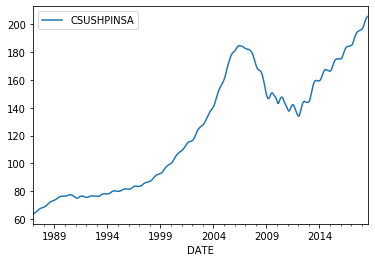

In [248]:
cs1.plot.line()
plt.show()

/Users/kytonhe/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 584.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


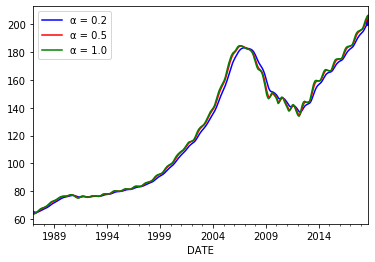

In [338]:
# Simple Exponential Smoothing
fit1 = SimpleExpSmoothing(cs1).fit(smoothing_level=0.2)
fcast1 = fit1.forecast(1).rename("\u03B1 = 0.2")
# plot
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(color='blue')



fit2 = SimpleExpSmoothing(cs1).fit(smoothing_level=0.5)
fcast2 = fit2.forecast(1).rename("\u03B1 = 0.5")
# plot
fcast2.plot(marker='.', color='red', legend=True)
fit2.fittedvalues.plot(color='red')


fit3 = SimpleExpSmoothing(cs1).fit()
fcast3 = fit3.forecast(1).rename('\u03B1 = %s'%fit3.model.params['smoothing_level'])
# plot
fcast3.plot(marker='.', color='green', legend=True)
fit3.fittedvalues.plot(color='green')

plt.show()

/Users/kytonhe/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


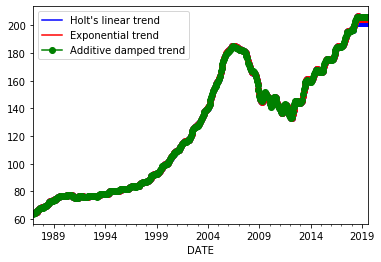

In [342]:
fit4 = Holt(cs1).fit(smoothing_level=1, smoothing_slope=0.2, optimized=False)
fcast4 = fit1.forecast(12).rename("Holt's linear trend")

fit5 = Holt(cs1, exponential=True).fit(smoothing_level=1, smoothing_slope=0.2, optimized=False)
fcast5 = fit2.forecast(12).rename("Exponential trend")

fit6 = Holt(cs1, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast6 = fit3.forecast(12).rename("Additive damped trend")


fit4.fittedvalues.plot(marker="o", color='blue')
fcast4.plot(color='blue', marker="o", legend=True)
fit5.fittedvalues.plot(marker="o", color='red')
fcast5.plot(color='red', marker="o", legend=True)
fit6.fittedvalues.plot(marker="o", color='green')
fcast6.plot(color='green', marker="o", legend=True)

plt.show()

In [339]:
SES02=fit1.fittedvalues.append(fcast1)
SES06=fit2.fittedvalues.append(fcast2)
SESAuto1=fit3.fittedvalues.append(fcast3)

In [325]:
SES=pd.concat([cs1,SES02,SES06,SESAuto1], axis=1)

In [328]:
SES=SES.rename(columns={"CSUSHPINSA":"Case-Shiller_index",0:"Alpha0.2",1:"Alpha0.6",2:"Alpha1"})

In [344]:
SES.to_excel("Case_shiller SES.xls")

,DATE,Case-Shiller_index,SMA_6,SMA_12,SMA_3,SMA_3_AbsError,SMA_6_AbsError,SMA_12_AbsError
0,1987-01-01,63.754,NaN,NaN,NaN,NaN,NaN,NaN
1,1987-02-01,64.153,NaN,NaN,NaN,NaN,NaN,NaN
2,1987-03-01,64.489,NaN,NaN,NaN,NaN,NaN,NaN
3,1987-04-01,64.994,NaN,NaN,64.132000,0.862000,NaN,NaN
4,1987-05-01,65.568,NaN,NaN,64.545333,1.022667,NaN,NaN
...,...,...,...,...,...,...,...,...
392,2019-09-01,212.138,209.662000,207.365500,211.473000,0.665000,2.476000,4.772500
393,2019-10-01,212.199,210.682333,207.913667,211.903333,0.295667,1.516667,4.285333
394,2019-11-01,212.419,211.392333,208.467000,212.102667,0.316333,1.026667,3.952000
395,2019-12-01,212.594,211.862500,209.059500,212.252000,0.342000,0.731500,3.534500
